In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import nntools as nt

In [79]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.MSE = nn.MSELoss(size_average=None, reduce=None, reduction='sum')
    def criterion(self, y, d):
        return self.MSE(y, d)

In [5]:
vgg = tv.models.vgg19(pretrained=True)

In [6]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
vgg.features[:2]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)

In [80]:
# Define the network with transfer learning

class VGG19Transfer(NNClassifier):
    def __init__(self, fine_tuning=False): #want to keep existing weights/biases
        super(VGG19Transfer, self).__init__()
        vgg = tv.models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        # Only maintain the feature space    
        self.net = nn.ModuleList()
        self.net = vgg.features
        # Change MaxPool to AvgPool
        self.net[4] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[9] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[18] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[27] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
        self.net[36] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
 
    def forward(self, x):
        rep = {}
        rep['c11'] = self.net[0](x)
        rep['r11'] = F.relu(rep['c11'] )
        rep['c12'] = self.net[2](rep['r11'] )
        rep['r12'] = F.relu(rep['r11'] )
        rep['p1'] = self.net[4](rep['c12'] )
        rep['c21'] = self.net[5](rep['p1'] )
        rep['r21'] = F.relu(rep['c21'] )
        rep['c22'] = self.net[7](rep['r21'] )
        rep['r22'] = F.relu(rep['c22'] )
        rep['p2'] = self.net[9](rep['r22'] )
        rep['c31'] = self.net[10](rep['p2'] )
        rep['r31'] = F.relu(rep['c31'] )
        rep['c32'] = self.net[12](rep['r31'] )
        rep['r32'] = F.relu(rep['c32'] )
        rep['c33'] = self.net[14](rep['r32'] )
        rep['r33'] = F.relu(rep['c33'] )
        rep['c34'] = self.net[16](rep['r33'] )
        rep['r34'] = F.relu(rep['c34'] )
        rep['p3'] = self.net[18](rep['r34'] )
        rep['c41'] = self.net[19](rep['p3'] )
        rep['r41'] = F.relu(rep['c41'] )
        rep['c42'] = self.net[21](rep['r41'] )
        rep['r42'] = F.relu(rep['c42'] )
        rep['c43'] = self.net[23](rep['r42'] )
        rep['r43'] = F.relu(rep['c43'] )
        rep['c44'] = self.net[25](rep['r43'] )
        rep['r44'] = F.relu(rep['c44'] )
        rep['p4'] = self.net[27](rep['r44'] )
        rep['c51'] = self.net[28](rep['p4'] )
        rep['r51'] = F.relu(rep['c51'] )
        rep['c52'] = self.net[30](rep['r51'] )
        rep['r52'] = F.relu(rep['c52'] )
        rep['c53'] = self.net[32](rep['r52'] )
        rep['r53'] = F.relu(rep['c53'] )
        rep['c54'] = self.net[34](rep['r53'] )
        rep['r54'] = F.relu(rep['c54'] )
        rep['p5'] = self.net[36](rep['r11'] )
        


        return rep #dictionary data structure; can change if you guys have better ideas

In [9]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [10]:
# net = VGG19Transfer()

# print(net)

In [11]:
# get images
transform = tv.transforms.Compose([
#     tv.transforms.Resize((500, 500)), #whatever size we want i guess?
    tv.transforms.ToTensor(),
#             tv.transforms.Normalize((0,0,0),(1,1,1)),
#     tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
    ])

photo_path = 'photo.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:]

art_path = 'art.jpg'
art = Image.open(art_path)
a = transform(art)
a = a[None,:,:,:]

x = torch.randn(3,500,500,requires_grad=True) # to allow updates!!
# x = x[None,:,:,:]

In [12]:
x.shape

torch.Size([3, 500, 500])

In [13]:
# get feature representations of artwork and photograph
# v = VGG19Transfer()
# P = v.forward(p)
# A = v.forward(a)

In [14]:
# A = v.forward(a)

In [15]:
# A['5_1'].shape

In [16]:
# Photograph feature response reshaped matrix (capital P^l)
# P1 = P['1'].view(64,-1)
# P2 = P['2'].view(128,-1)
# P3 = P['3'].view(256,-1)
# P4 = P['4'].view(512,-1)
# P5 = P['5'].view(512,-1)

In [17]:
# Artwork feature response reshaped matrix (capital A^l)
# A1 = A['1'].view(64,-1)
# A2 = A['2'].view(128,-1)
# A3 = A['3'].view(256,-1)
# A4 = A['4'].view(512,-1)
# A5 = A['5'].view(512,-1)

In [18]:
def Gram(featresp):
    return torch.mm(featresp,featresp.t()) # NlxNl (from paper)

In [86]:
def bruh(photo,art,net,epochs,lr=.01):
    
    h = photo.shape[2]
    w = photo.shape[3]
    x = torch.randn(1,3,h,w,requires_grad=True,device='cuda')  
    
    optimizer = torch.optim.Adam([x], lr=lr)
    
    P = net.forward(photo)
    P42NL = P['r42'].shape[1]
    P42 = P['r42'].view(P42NL,-1)

    
    A = net.forward(art) 
    A1 = A['r11'].view(64,-1)
    A2 = A['r21'].view(128,-1)
    A3 = A['r32'].view(256,-1)
    A4 = A['r43'].view(512,-1)
    A5 = A['r54'].view(512,-1)
    
    
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        outputs = net.forward(x)
        
        out42 = outputs['r42'].view(P42NL, -1)
        
        out1 = outputs['r11'].view(64,-1)
        out2 = outputs['r21'].view(128,-1)
        out3 = outputs['r32'].view(256,-1)
        out4 = outputs['r43'].view(512,-1)
        out5 = outputs['r54'].view(512,-1)

        #get content loss
        #define criterion
#         contentloss = ((out42-P42)**2).sum() / 2
        contentloss = net.criterion(out42,P42)
        
        #get style gram matrices
        gram1 = Gram(out1)
        gram2 = Gram(out2)
        gram3 = Gram(out3)
        gram4 = Gram(out4)
        gram5 = Gram(out5)
        
        gram1o = Gram(A1)
        gram2o = Gram(A2)
        gram3o = Gram(A3)
        gram4o = Gram(A4)
        gram5o = Gram(A5)
        
        #style loss
        E1 = 1/(4*(out1.shape[0])**2*(out1.shape[1])**2) * net.criterion(gram1,gram1o)
        E2 = 1/(4*(out2.shape[0])**2*(out2.shape[1])**2) * net.criterion(gram2,gram2o)
        E3 = 1/(4*(out3.shape[0])**2*(out3.shape[1])**2) * net.criterion(gram3,gram3o)
        E4 = 1/(4*(out4.shape[0])**2*(out4.shape[1])**2) * net.criterion(gram4,gram4o)
        E5 = 1/(4*(out5.shape[0])**2*(out5.shape[1])**2) * net.criterion(gram5,gram5o)
        
        #total style loss
        styleloss = (E1+E2+E3+E4+E5)/5
        
        #get total loss
        loss = contentloss + 1000*styleloss
        
        #backprop
        loss.backward(retain_graph=True)
        
        #parameter search
        optimizer.step()
        if epoch % 25 == 0:
            print(loss)
            print(epoch)

#         x[0,0,0:250,0:250] = 1
    return x

In [87]:
# get images
transform = tv.transforms.Compose([
#     tv.transforms.Resize((500, 500)), #whatever size we want i guess?
    tv.transforms.ToTensor(),
#             tv.transforms.Normalize((0,0,0),(1,1,1)),
    tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
    ])

photo_path = 'photo.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:]

art_path = 'art.jpg'
art = Image.open(art_path)
a = transform(art)
a = a[None,:,:,:]

# x = torch.randn(3,500,500,requires_grad=True) # to allow updates!!
# x = x[None,:,:,:]

In [88]:
p = p.to(device)
a = a.to(device)
v = VGG19Transfer().to(device)

In [89]:
aa = bruh(p,a,v,5000)

tensor(862276.9375, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(481926.9688, device='cuda:0', grad_fn=<AddBackward0>)
25
tensor(348007.7500, device='cuda:0', grad_fn=<AddBackward0>)
50
tensor(239746.8281, device='cuda:0', grad_fn=<AddBackward0>)
75
tensor(169349.5781, device='cuda:0', grad_fn=<AddBackward0>)
100
tensor(125658.6016, device='cuda:0', grad_fn=<AddBackward0>)
125
tensor(95733.0547, device='cuda:0', grad_fn=<AddBackward0>)
150
tensor(75099.3203, device='cuda:0', grad_fn=<AddBackward0>)
175
tensor(61372.3164, device='cuda:0', grad_fn=<AddBackward0>)
200
tensor(51229.8555, device='cuda:0', grad_fn=<AddBackward0>)
225
tensor(43553.5938, device='cuda:0', grad_fn=<AddBackward0>)
250
tensor(37729.7031, device='cuda:0', grad_fn=<AddBackward0>)
275
tensor(33277.5547, device='cuda:0', grad_fn=<AddBackward0>)
300
tensor(29823.2715, device='cuda:0', grad_fn=<AddBackward0>)
325
tensor(27108.3750, device='cuda:0', grad_fn=<AddBackward0>)
350
tensor(25012.9043, device='cuda:0', gra

<IPython.core.display.Javascript object>


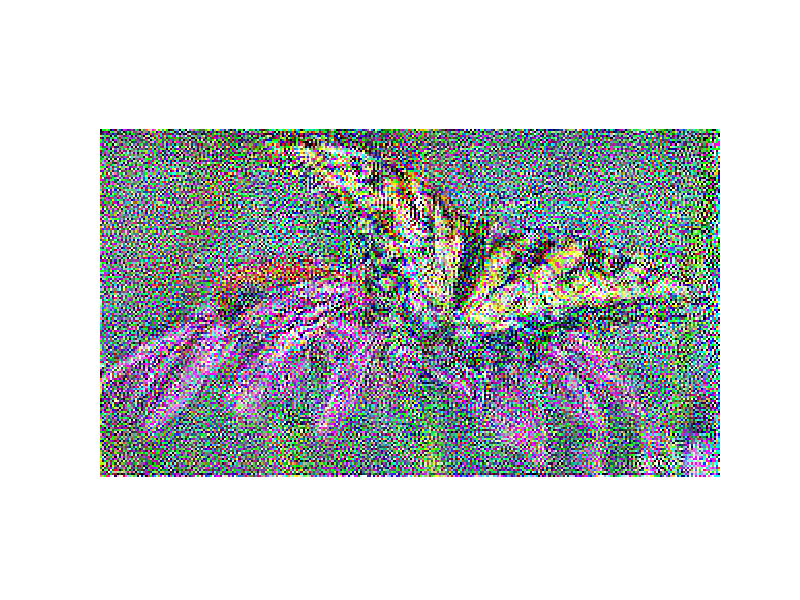

In [90]:
aaa = (aa.detach().cpu())
h = aa.shape[2]
aaa = aaa.view(3,h,-1)
myimshow(aaa)



<IPython.core.display.Javascript object>


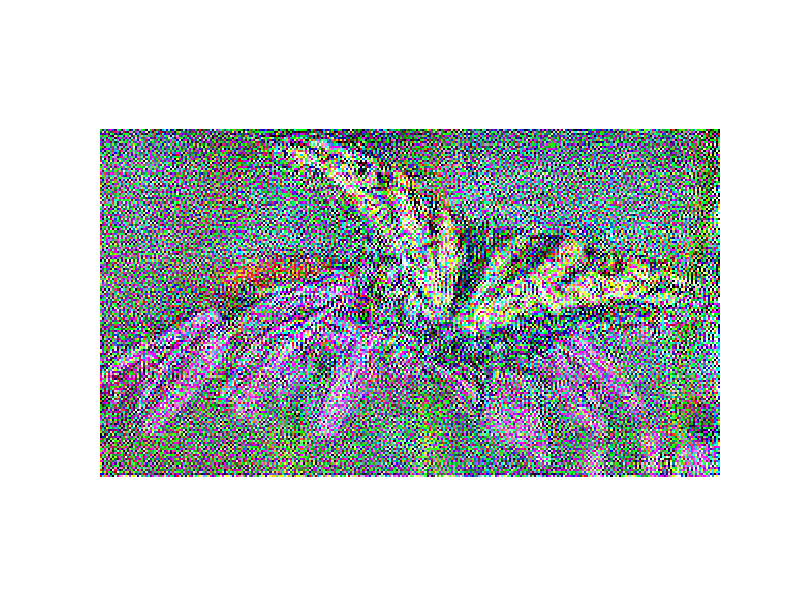

In [44]:
myimshow(p.view(3,h,-1))

In [45]:
hh = a.shape[2]
myimshow(a.view(3,hh,-1))

In [ ]:
plt.subplot(1, 2, 1)
myimshow(p.view(3,h,-1))
plt.subplot(1, 2, 2)
hh = a.shape[2]
myimshow(a.view(3,hh,-1))

In [ ]:
imgplot = plt.imshow(aaa.moveaxis([0,1,2],[1,2,0]))

In [ ]:
import glob
from PIL import Image

images=glob.glob("/root/data/amz//train_small/*jpg")
for image in images:
img = Image.open(image)
trans = transforms.ToPILImage()
trans1 = transforms.ToTensor()
plt.imshow(trans(trans1(img)))

In [ ]:
# a = v.parameters()
# list(a)
# print(list(v.parameters()))
v = VGG19Transfer(x)

In [ ]:
#test visualization of feature representation
b = P['1']
bb = b[0,0,:,:].detach() #2nd axis is different feature map of layer defined above as b = g['layernumber']
bb.numpy()
plt.imshow(bb.numpy()) # look at the feature map!